<img src="https://cainvas-static.s3.amazonaws.com/media/user_data/Kanan_M/3AVd.gif" width="750" align="center">

## Importing necessary libraries

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2 
import os

### Extracting files from zip

In [2]:
import zipfile
archieve = zipfile.ZipFile('tomato.zip')
archieve.extractall()

## Reading and preprocessing images and labels

In [5]:
# In our main folder we have 2 folders, train and val, namely and each of them contains 10 folders, 1 for healthy leaves, the others for diseases
train_images = []
train_labels = []
test_images = []
test_labels = []

dataset_path = 'tomato'
for train_test_folder in os.listdir(dataset_path):
    # if we are in train folder, we go through disease/healthy folders there
    if train_test_folder == 'train':
        train_path = os.path.join(dataset_path, train_test_folder)
        # for each disease/healthy folder we take folder name as label and go through it to read images
        for disease_folder in os.listdir(train_path):
            disease_path = os.path.join(train_path, disease_folder)
            label = disease_folder.split('___')[1]
            # in each disease/healthy folder we read files with jpg format, i.e images and normalize them
            for file in os.listdir(disease_path):
                if file.endswith('jpg'):
                    img_path = os.path.join(disease_path, file)
                    img = cv2.imread(img_path)
                    r, g, b = img[:, :, 0]/255, img[:, :, 1]/255, img[:, :, 2]/255
                    img = np.dstack((r, g, b))
                    train_images.append(img)
                    train_labels.append(label)
                    
    # if we are in val folder, we go through disease/healthy folders there         
    if train_test_folder == 'val':
        test_path = os.path.join(dataset_path, train_test_folder)
        # for each disease/healthy folder we take folder name as label and go through it to read images
        for disease_folder in os.listdir(test_path):
            disease_path = os.path.join(test_path, disease_folder)
            label = disease_folder.split('___')[1]
            # in each disease/healthy folder we read files with jpg format, i.e images and normalize them
            for file in os.listdir(disease_path):
                if file.endswith('jpg'):
                    img_path = os.path.join(disease_path, file)
                    img = cv2.imread(img_path)
                    r, g, b = img[:, :, 0]/255, img[:, :, 1]/255, img[:, :, 2]/255
                    img = np.dstack((r, g, b))
                    test_images.append(img)
                    test_labels.append(label)
                    
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
print('Shape of the stacked train images:', train_images.shape)
print('Shape of the train labels:', train_labels.shape)
print('Shape of the stacked test images:', test_images.shape)
print('Shape of the test_labels:', test_labels.shape)

Shape of the stacked train images: (10000, 64, 64, 3)
Shape of the train labels: (10000,)
Shape of the stacked test images: (1000, 64, 64, 3)
Shape of the test_labels: (1000,)


## Checking for all leaf categories

In [7]:
unique_labels = np.unique(train_labels)
for i in unique_labels:
    print(i)

Bacterial_spot
Early_blight
Late_blight
Leaf_Mold
Septoria_leaf_spot
Spider_mites Two-spotted_spider_mite
Target_Spot
Tomato_Yellow_Leaf_Curl_Virus
Tomato_mosaic_virus
healthy


## Encoder function that uses one hot encoding strategy to change string labels into numerical values

In [5]:
def encoder(labels):
    train_labels = np.zeros((labels.shape[0], 10))
    dic = {'Bacterial_spot':0, 'Early_blight':1, 'Late_blight':2, 'Leaf_Mold':3, 'Septoria_leaf_spot':4, 'Spider_mites Two-spotted_spider_mite':5,
          'Target_Spot':6, 'Tomato_Yellow_Leaf_Curl_Virus':7, 'Tomato_mosaic_virus':8, 'healthy':9}
    for i in range(len(labels)):
        train_labels[i, dic[labels[i]]] = 1
    return train_labels

## Decoder function that will transform predicted results into string labels

In [6]:
def decoder(labels):
    preds = np.argmax(labels, axis=1)
    test_labels = []
    dic = {0:'Bacterial_spot', 1:'Early_blight', 2:'Late_blight', 3:'Leaf_Mold', 4:'Septoria_leaf_spot', 5:'Spider_mites Two-spotted_spider_mite',
          6:'Target_Spot', 7:'Tomato_Yellow_Leaf_Curl_Virus', 8:'Tomato_mosaic_virus', 9:'healthy'}
    
    for i in preds:
        test_labels.append(dic[i])
    return np.array(test_labels)
    

## Let's visualize 2 images from each category with their corresponding labels to have an idea about our data

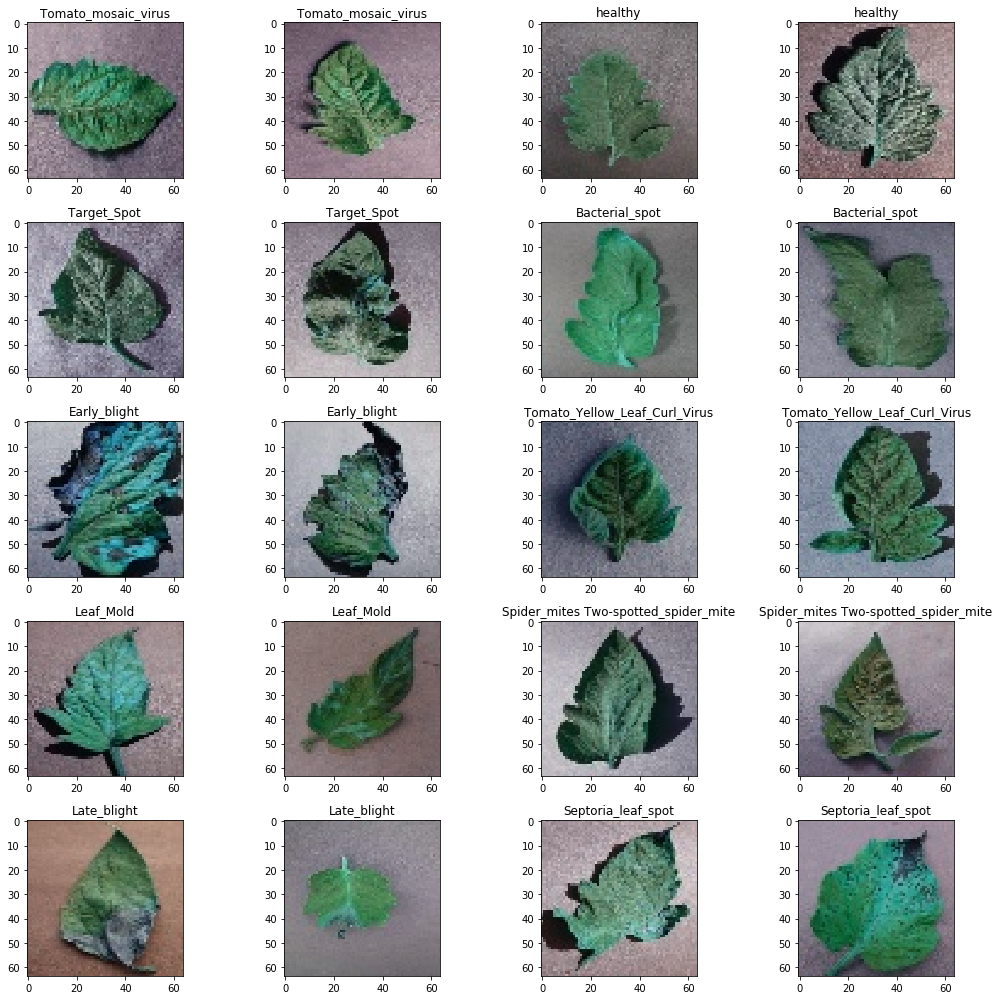

In [7]:
row = 5
col = 4
fig, axes = plt.subplots(row, col, figsize=(14, 14))
c = 0
count = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(train_images[c])
        axes[i][j].set_title(train_labels[c])
        c += 500
        
plt.tight_layout()
plt.show()

## Encoding our labels

In [8]:
train_labels = encoder(train_labels)
test_labels = encoder(test_labels)

## Splitting our data into train and validation sets and augmenting train images

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, random_state=123)

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen_train = ImageDataGenerator(horizontal_flip=True, vertical_flip=True)
train_iter = datagen_train.flow(X_train, y_train, batch_size=64)

## Building our model and train 

In [5]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = tf.keras.Sequential([
    Conv2D(8, (3, 3), input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    
    Flatten(),
    Dense(40, activation='relu'),
    Dense(10, activation='softmax')
    
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 64, 64, 8)         224       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)             

### Visualizing out CNN Arhitecture with visualkeras Library

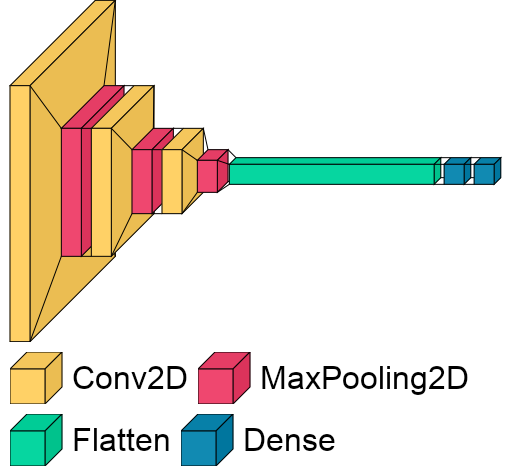

In [6]:
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32) 
visualkeras.layered_view(model, legend=True, font=font, to_file='Tomato_Disease_Classifier.png') 

In [14]:
# training our model with callbacks: if we have no improvement on validation loss for 10 epochs, we stop and create a checkpoint
cb = [
        tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
        tf.keras.callbacks.ModelCheckpoint('model_tomato.h5', monitor = "val_loss", save_best_only = True)
    ]

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_iter, steps_per_epoch=len(train_iter), epochs=120, validation_data=(X_val, y_val), callbacks = cb)

Epoch 1/120
118/118 [==============================] - 6s 50ms/step - loss: 2.1637 - accuracy: 0.2116 - val_loss: 1.8064 - val_accuracy: 0.3712
Epoch 2/120
118/118 [==============================] - 9s 74ms/step - loss: 1.5823 - accuracy: 0.4621 - val_loss: 1.4524 - val_accuracy: 0.4832
Epoch 3/120
118/118 [==============================] - 7s 58ms/step - loss: 1.3273 - accuracy: 0.5400 - val_loss: 1.2584 - val_accuracy: 0.5624
Epoch 4/120
118/118 [==============================] - 7s 56ms/step - loss: 1.1453 - accuracy: 0.6037 - val_loss: 1.1510 - val_accuracy: 0.5920
Epoch 5/120
118/118 [==============================] - 6s 54ms/step - loss: 1.0011 - accuracy: 0.6580 - val_loss: 0.9455 - val_accuracy: 0.6724
Epoch 6/120
118/118 [==============================] - 6s 53ms/step - loss: 0.9145 - accuracy: 0.6864 - val_loss: 0.8951 - val_accuracy: 0.6976
Epoch 7/120
118/118 [==============================] - 6s 54ms/step - loss: 0.8409 - accuracy: 0.7239 - val_loss: 0.8108 - val_accuracy:

## Visualizing our accuracy, loss and saving the model

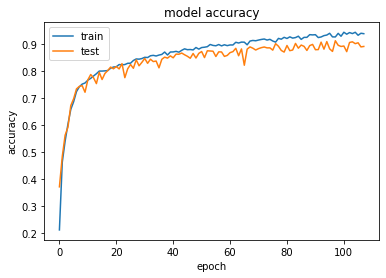

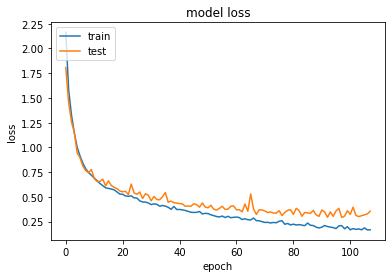

Weights saved.


In [15]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

model.save('model_tomato.h5')
print('Weights saved.')

## Testing our model

In [16]:
acc = model.evaluate(test_images, test_labels)

32/32 [==============================] - 0s 8ms/step - loss: 0.3620 - accuracy: 0.8980


In [17]:
# decoding the labels
predicted_labels = decoder(model.predict(test_images))
test_labels = decoder(test_labels)

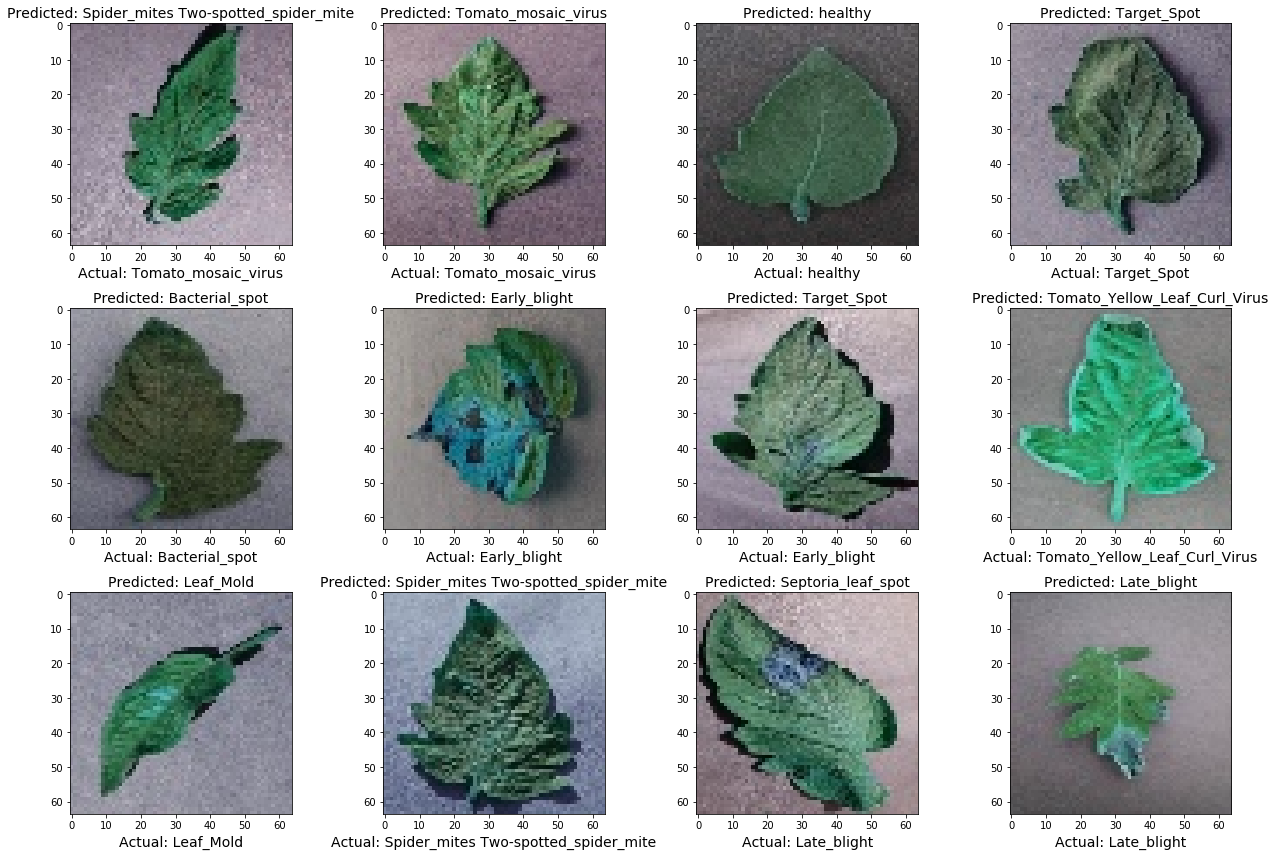

In [20]:
# visualizing some of our results
row = 3
col = 4
fig, axes = plt.subplots(row, col, figsize=(18, 12))
c = 0
count = 0
for i in range(row):
    for j in range(col):
        axes[i][j].imshow(test_images[c])
        axes[i][j].set_title(f'Predicted: {predicted_labels[c]}', fontsize=14)
        axes[i][j].set_xlabel(f'Actual: {test_labels[c]}', fontsize=14)
        if (predicted_labels[c] != test_labels[c]):
            count+=1
        c += 80
        
plt.tight_layout()
plt.show()